In [ ]:
from google.colab import drive
drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Mounted at /content/drive


In [ ]:
!pip install keras-layer-normalization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
class Config:
  DATASET_PATH ="/content/drive/My Drive/ColabNotebook2/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train"
  SINGLE_TEST_PATH = "/content/drive/My Drive/ColabNotebook2/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test020"
  BATCH_SIZE = 4
  EPOCHS = 3
  MODEL_PATH = "/content/drive/My Drive/ColabNotebook2/callback/model_lstm.hdf5"

In [ ]:
from os import listdir
from os.path import isfile, join, isdir
from PIL import Image
import numpy as np
import shelve

def get_clips_by_stride(stride, frames_list, sequence_size):
    """ For data augmenting purposes.
    Parameters
    ----------
    stride : int
        The desired distance between two consecutive frames
    frames_list : list
        A list of sorted frames of shape 256 X 256
    sequence_size: int
        The size of the desired LSTM sequence
    Returns
    -------
    list
        A list of clips , 10 frames each
    """
    clips = []
    sz = len(frames_list)
    clip = np.zeros(shape=(sequence_size, 256, 256, 1))
    cnt = 0
    for start in range(0, stride):
        for i in range(start, sz, stride):
            clip[cnt, :, :, 0] = frames_list[i]
            cnt = cnt + 1
            if cnt == sequence_size:
                clips.append(np.copy(clip))
                cnt = 0
   
def get_training_set():
    """
    Returns
    -------
    list
        A list of training sequences of shape (NUMBER_OF_SEQUENCES,SINGLE_SEQUENCE_SIZE,FRAME_WIDTH,FRAME_HEIGHT,1)
    """
    #####################################
    # cache = shelve.open(Config.CACHE_PATH)
    # return cache["datasetLSTM"]
    #####################################
    clips = []
    # loop over the training folders (Train000,Train001,..)
    for f in sorted(listdir(Config.DATASET_PATH)):
        if isdir(join(Config.DATASET_PATH, f)):
            all_frames = []
            # loop over all the images in the folder (0.tif,1.tif,..,199.tif)
            for c in sorted(listdir(join(Config.DATASET_PATH, f))):
                if str(join(join(Config.DATASET_PATH, f), c))[-3:] == "tif":
                    img = Image.open(join(join(Config.DATASET_PATH, f), c)).resize((256, 256))
                    img = np.array(img, dtype=np.float32) / 256.0
                    all_frames.append(img)
            # get the 10-frames sequences from the list of images after applying data augmentation
            for stride in range(1, 3):
                clips.extend(get_clips_by_stride(stride=stride, frames_list=all_frames, sequence_size=10))

  
    return clips


In [ ]:
import keras
from keras.layers import Conv2DTranspose, ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D, LayerNormalization
from keras.models import Sequential, load_model
def get_model(reload_model=True):
    """
    Parameters
    ----------
    reload_model : bool
        Load saved model or retrain it
    """
    if not reload_model:
        return load_model(Config.MODEL_PATH,custom_objects={'LayerNormalization': LayerNormalization})
    training_set = get_training_set()
    training_set = np.array(training_set)
    training_set = training_set.reshape(-1,10,256,256,1)
    seq = Sequential()
    seq.add(TimeDistributed(Conv2D(128, (11, 11), strides=4, padding="same"), batch_input_shape=(None, 10, 256, 256, 1)))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(64, (5, 5), strides=2, padding="same")))
    seq.add(LayerNormalization())
    # # # # #
    seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    # # # # #
    seq.add(TimeDistributed(Conv2DTranspose(64, (5, 5), strides=2, padding="same")))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2DTranspose(128, (11, 11), strides=4, padding="same")))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(1, (11, 11), activation="sigmoid", padding="same")))
    print(seq.summary())
    seq.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=1e-4, decay=1e-5, epsilon=1e-6))
    seq.fit(training_set, training_set,batch_size=Config.BATCH_SIZE, epochs=Config.EPOCHS, shuffle=False)
    seq.save(Config.MODEL_PATH)
    return seq

In [ ]:
def get_single_test():
    sz = 200
    test = np.zeros(shape=(sz, 256, 256, 1))
    cnt = 0
    for f in sorted(listdir(Config.SINGLE_TEST_PATH)):
        if str(join(Config.SINGLE_TEST_PATH, f))[-3:] == "tif":
            img = Image.open(join(Config.SINGLE_TEST_PATH, f)).resize((256, 256))
            img = np.array(img, dtype=np.float32) / 256.0
            test[cnt, :, :, 0] = img
            cnt = cnt + 1
   
    return test

In [ ]:
import matplotlib.pyplot as plt
import numpy
import pandas as pd
x=0
def evaluate():
    model = get_model(False)
    print("got model")
    test = get_single_test()
    print(test.shape)
    sz = test.shape[0] - 10 + 1
    sequences = np.zeros((sz, 10, 256, 256, 1))
    # apply the sliding window technique to get the sequences
    for i in range(0, sz):
        clip = np.zeros((10, 256, 256, 1))
        for j in range(0, 10):
            clip[j] = test[i + j, :, :, :]
        sequences[i] = clip
    #x=sequences
    

    print("got data")
    # get the reconstruction cost of all the sequences
    reconstructed_sequences = model.predict(sequences,batch_size=4)
    sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0,sz)])
    sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
    sr = 1.0 - sa
    

    # plot the regularity scores
  
    plt.plot(sr,color='green')
    plt.ylabel('Regularity score Sr(t)')
    plt.xlabel('Frame t')
    plt.show()
    print(sr)
    DF = pd.DataFrame(sr)
    DF.to_csv("data1.csv")
  

got model
(200, 256, 256, 1)
got data
48/48 [==============================] - 21s 424ms/step


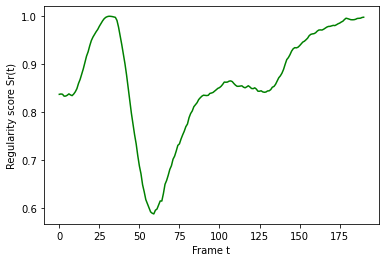

[0.83707971 0.8378279  0.83724869 0.83328902 0.83346704 0.83527819
 0.83801913 0.83583223 0.83438353 0.83772216 0.84241444 0.84894539
 0.85984702 0.86818041 0.87942197 0.89039391 0.90353782 0.91674311
 0.92586691 0.93841178 0.94920761 0.95646845 0.96200806 0.96772826
 0.97252266 0.97904196 0.98452173 0.9902294  0.99477103 0.9976773
 0.99923587 1.         0.99980939 0.99937006 0.99850519 0.99772427
 0.99129576 0.97708722 0.95927346 0.94074049 0.92135208 0.90075648
 0.87728744 0.85114426 0.82446579 0.79773533 0.77563231 0.75281633
 0.73349746 0.70889127 0.68749058 0.67120908 0.64831301 0.63388261
 0.61747879 0.60885957 0.60038352 0.59187394 0.58902467 0.58760256
 0.59525707 0.59785008 0.6061112  0.61460624 0.61447243 0.6301062
 0.64941295 0.65738341 0.66828206 0.68055954 0.68813359 0.70171844
 0.70822039 0.71881183 0.73060507 0.73377463 0.74386866 0.752394
 0.7600673  0.76963449 0.7750658  0.78842416 0.79704715 0.80242263
 0.81124058 0.8154877  0.81959518 0.82609749 0.82991184 0.83321862

In [ ]:
evaluate()

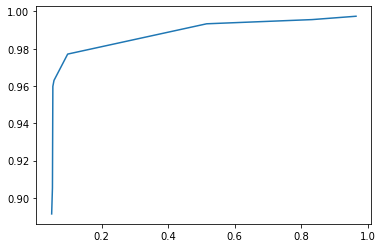

AUC: 90.52286060825001


In [ ]:
import sklearn
from sklearn.metrics import roc_curve
from sklearn.metrics import  auc
import matplotlib.pyplot as plt
import numpy as np
fpr = np.array([0.05, 0.052346, 0.053567, 0.057,0.0981433,0.516,0.833,0.9653])
tpr = np.array([0.89142,0.9054,0.9598,0.963,0.97711,0.99335,0.9956,0.9974])
plt.plot(fpr, tpr)
plt.show()
print ("AUC:",  100*sklearn.metrics.auc(fpr, tpr))

In [ ]:
import sklearn
from sklearn.metrics import roc_curve
from sklearn.metrics import  auc
import matplotlib.pyplot as plt
import numpy as np
fpr = np.array([0.18,0.31,0.49,0.57,0.8])
tpr = np.array([0.69,1,1,1,1])
plt.plot(x=fpr, tpr)
plt.show()
print ("AUC:",  100*sklearn.metrics.auc(fpr, tpr))

SyntaxError: ignored